In [328]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [329]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/NVL Historical Data 2018.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [330]:
df1=df.reset_index()['Price']
df1.head()

0    27815
1    28410
2    28707
3    28962
4    29556
Name: Price, dtype: int64

In [331]:
df1

0       27815
1       28410
2       28707
3       28962
4       29556
        ...  
1547    16700
1548    16500
1549    16550
1550    17100
1551    17100
Name: Price, Length: 1552, dtype: int64

In [332]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [333]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = int(0.1 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [334]:
test_size

155

In [335]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [336]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [337]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [338]:
X_train.shape

(1295, 100, 1)

In [339]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [340]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
21/21 [==============================] - 3s 23ms/step - loss: 0.0474
Epoch 2/100
21/21 [==============================] - 0s 22ms/step - loss: 0.0020
Epoch 3/100
21/21 [==============================] - 0s 22ms/step - loss: 7.3815e-04
Epoch 4/100
21/21 [==============================] - 0s 22ms/step - loss: 5.9460e-04
Epoch 5/100
21/21 [==============================] - 0s 22ms/step - loss: 5.6323e-04
Epoch 6/100
21/21 [==============================] - 0s 20ms/step - loss: 5.5478e-04
Epoch 7/100
21/21 [==============================] - 0s 21ms/step - loss: 5.2488e-04
Epoch 8/100
21/21 [==============================] - 0s 21ms/step - loss: 5.1396e-04
Epoch 9/100
21/21 [==============================] - 0s 21ms/step - loss: 4.8994e-04
Epoch 10/100
21/21 [==============================] - 0s 19ms/step - loss: 5.0357e-04
Epoch 11/100
21/21 [==============================] - 0s 18ms/step - loss: 4.9035e-04
Epoch 12/100
21/21 [==============================] - 0s 20ms/step - lo

In [341]:
# 10. Dự báo dữ liệu test
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


2/2 [==============================] - 0s 17ms/step


In [342]:
# 11. Chuẩn hóa dữ liệu y_pred, y_test
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [343]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 378.0189882212463


In [344]:
x_input.shape

(1, 250, 1)

In [345]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=96      # Thay đổi phù hợp
i=0
while(i<30):

    if(len(temp_input)>250):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.08660786]
97
[0.08660786]
98
[0.08660786]
99
[0.08660786]
100
[0.08660786]
101
[0.08660786]
102
[0.08660786]
103
[0.08660786]
104
[0.08660786]
105
[0.08660786]
106
[0.08660786]
107
[0.08660786]
108
[0.08660786]
109
[0.08660786]
110
[0.08660786]
111
[0.08660786]
112
[0.08660786]
113
[0.08660786]
114
[0.08660786]
115
[0.08660786]
116
[0.08660786]
117
[0.08660786]
118
[0.08660786]
119
[0.08660786]
120
[0.08660786]
121
[0.08660786]
122
[0.08660786]
123
[0.08660786]
124
[0.08660786]
125
[0.08660786]
126


In [346]:
test_data_index

RangeIndex(start=1342, stop=1552, step=1)

In [347]:
scaler.inverse_transform(test_data).shape

(156, 1)

In [348]:
y_pred.shape

(55, 1)

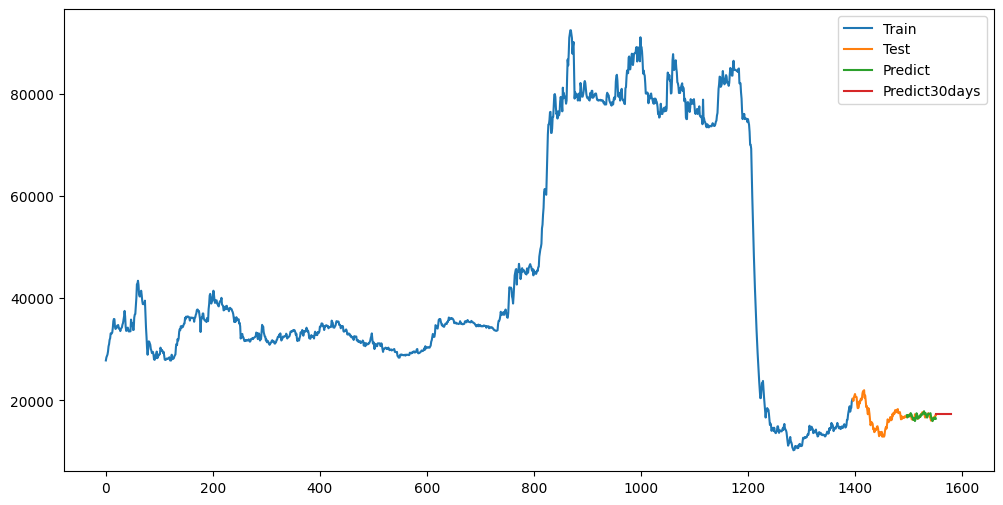

In [349]:
# 14.Vẽ hình
plt.figure(figsize=(12,6))
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size+1, step=1)
plt.plot(test_data_index,(y_pred))

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))

plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()